In this notebook, we do a preliminary exploration of the data.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import pydicom
import seaborn as sns

In [2]:
manifest = pd.read_csv("../data/raw/rsna-intracranial-hemorrhage-detection/stage_2_train.csv")
manifest.head(10)

,ID,Label
0,ID_12cadc6af_epidural,0
1,ID_12cadc6af_intraparenchymal,0
2,ID_12cadc6af_intraventricular,0
3,ID_12cadc6af_subarachnoid,0
4,ID_12cadc6af_subdural,0
5,ID_12cadc6af_any,0
6,ID_38fd7baa0_epidural,0
7,ID_38fd7baa0_intraparenchymal,0
8,ID_38fd7baa0_intraventricular,0
9,ID_38fd7baa0_subarachnoid,0


In [3]:
manifest.shape

(4516842, 2)

In [4]:
manifest[manifest["ID"].duplicated()]

,ID,Label
56346,ID_a64d5deed_epidural,0
56347,ID_a64d5deed_intraparenchymal,0
56348,ID_a64d5deed_intraventricular,0
56349,ID_a64d5deed_subarachnoid,0
56350,ID_a64d5deed_subdural,0
56351,ID_a64d5deed_any,0
1171830,ID_854fba667_epidural,0
1171831,ID_854fba667_intraparenchymal,0
1171832,ID_854fba667_intraventricular,0
1171833,ID_854fba667_subarachnoid,0


Looks like there are some duplicates, we'll need to remove them.

In [5]:
manifest = manifest.drop_duplicates(subset="ID")

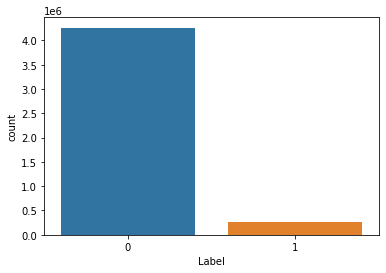

In [6]:
sns.countplot(x="Label", data=manifest)

In [7]:
manifest["Label"].value_counts()

0    4260576
1     256242
Name: Label, dtype: int64

Looks like the data is incredibly imbalanced when it comes to whether a sub-bleed exists at all. However, this isn't quite representative of bleeds per sample since this data is on the sub-bleed level.

In [8]:
split_id = manifest["ID"].str.rsplit('_', n=1, expand=True)
manifest["ID"] = split_id[0]
manifest["Subtype"] = split_id[1]

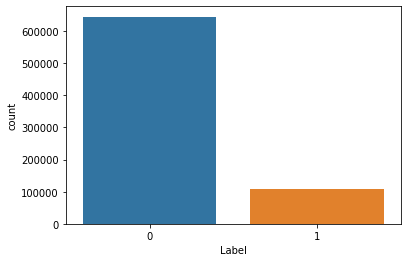

In [9]:
sns.countplot(x="Label", data=manifest[manifest["Subtype"] == "any"])

In [10]:
manifest[manifest["Subtype"] == "any"]["Label"].value_counts()

0    644870
1    107933
Name: Label, dtype: int64

Ok, this is not nearly as bad, though still imbalanced. Perhaps with some data augmentation, we can balance the data. 

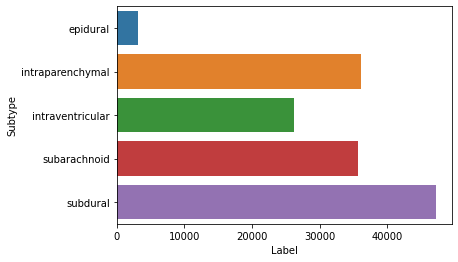

In [11]:
sns.barplot(x="Label", y="Subtype", data=manifest[manifest["Subtype"] != "any"].groupby("Subtype").sum().reset_index())

In [12]:
manifest[manifest["Subtype"] != "any"].groupby("Subtype").sum()

,Label
Subtype,
epidural,3145
intraparenchymal,36118
intraventricular,26205
subarachnoid,35675
subdural,47166


Looks like the subtypes are fairly balanced except for epidural bleeds, where there's only a few of those compared to the others. Since we are focusing on any bleed at first we don't need to worry about this, but perhaps later down the line this may prove worrisome.

In [13]:
first_id = manifest.iloc[0, :]["ID"]
first_dcm = pydicom.dcmread(f"../data/raw/rsna-intracranial-hemorrhage-detection/stage_2_train/{first_id}.dcm")
first_dcm

(0008, 0018) SOP Instance UID                    UI: ID_12cadc6af
(0008, 0060) Modality                            CS: 'CT'
(0010, 0020) Patient ID                          LO: 'ID_2eb3925f'
(0020, 000d) Study Instance UID                  UI: ID_6dec708c74
(0020, 000e) Series Instance UID                 UI: ID_1b17a4a944
(0020, 0010) Study ID                            SH: ''
(0020, 0032) Image Position (Patient)            DS: [-125.000, -145.337, 71.652]
(0020, 0037) Image Orientation (Patient)         DS: [1.000000, 0.000000, 0.000000, 0.000000, 0.976296, -0.216440]
(0028, 0002) Samples per Pixel                   US: 1
(0028, 0004) Photometric Interpretation          CS: 'MONOCHROME2'
(0028, 0010) Rows                                US: 512
(0028, 0011) Columns                             US: 512
(0028, 0030) Pixel Spacing                       DS: [0.488281, 0.488281]
(0028, 0100) Bits Allocated                      US: 16
(0028, 0101) Bits Stored                         US: 16


In [14]:
first_dcm.pixel_array

array([[-2000, -2000, -2000, ..., -2000, -2000, -2000],
       [-2000, -2000, -2000, ..., -2000, -2000, -2000],
       [-2000, -2000, -2000, ..., -2000, -2000, -2000],
       ...,
       [-2000, -2000, -2000, ..., -2000, -2000, -2000],
       [-2000, -2000, -2000, ..., -2000, -2000, -2000],
       [-2000, -2000, -2000, ..., -2000, -2000, -2000]], dtype=int16)

In [15]:
first_dcm.pixel_array.shape

(512, 512)

In [16]:
first_dcm.pixel_array.nbytes

524288

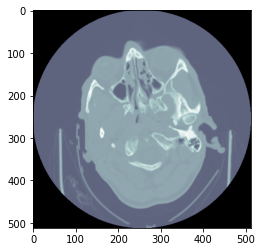

In [17]:
plt.imshow(first_dcm.pixel_array, cmap=plt.cm.bone)

Let's look at the first five where a hemorrhage was not detected.

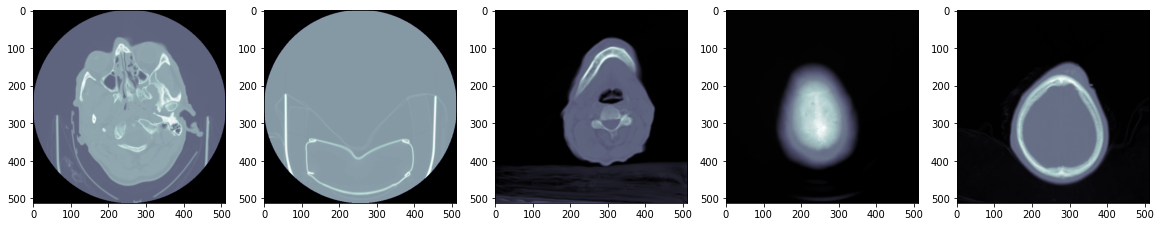

In [18]:
fig, axs = plt.subplots(1, 5, figsize=(20, 20))
for i, id in enumerate(manifest[(manifest["Subtype"] == "any") & (manifest["Label"] == 0)].head()["ID"]):
    dcm = pydicom.dcmread(f"../data/raw/rsna-intracranial-hemorrhage-detection/stage_2_train/{id}.dcm")
    axs[i].imshow(dcm.pixel_array, cmap=plt.cm.bone)

And now five where one was detected.

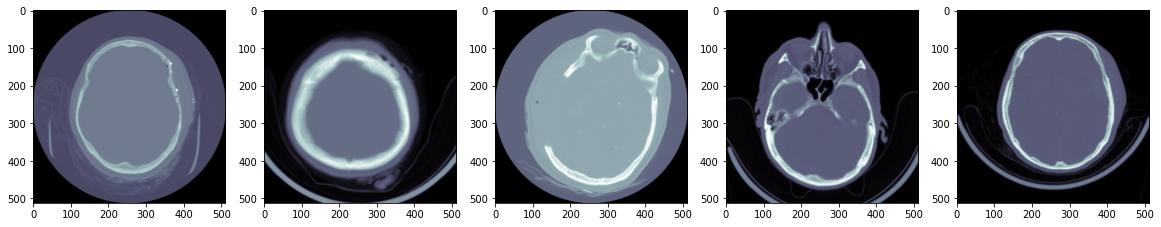

In [19]:
fig, axs = plt.subplots(1, 5, figsize=(20, 20))
for i, id in enumerate(manifest[(manifest["Subtype"] == "any") & (manifest["Label"] == 1)].head()["ID"]):
    dcm = pydicom.dcmread(f"../data/raw/rsna-intracranial-hemorrhage-detection/stage_2_train/{id}.dcm")
    axs[i].imshow(dcm.pixel_array, cmap=plt.cm.bone)

I can't really make out anything interesting, but I'm no radiologist so /shrug. There are windowing techniques that can be used, however those are designed for humans to interpret as our eyes cannot distinguish between many shades of grey, however, that's not an issue for computers. For this project, let's just focus on the images as they are.